# Fitting data with a grid of model spectra

In this tutorial, we will fit spectra and photometric fluxes of [beta Pic b](http://exoplanet.eu/catalog/beta_pic_b/) with the synthetic spectra from a radiative-convective equilibrium atmosphere model. Here we will use [DRIFT-PHOENIX](https://leap2010blog.wordpress.com/2014/07/03/drift-phoenix-atmosphere-models-creating-new-worlds/) but there are also [several other models](https://species.readthedocs.io/en/latest/overview.html#supported-data) supported by `species`.

## Getting started

We start by setting the library path of ``MultiNest`` (see [installation instructions](https://johannesbuchner.github.io/PyMultiNest/install.html#building-the-libraries)), which is required for the Bayesian inference.

In [1]:
import os
os.environ['DYLD_LIBRARY_PATH'] = '/Users/tomasstolker/applications/MultiNest/lib'

We also need to import [urllib](https://docs.python.org/3/library/urllib.html) and 
the `species` toolkit.

In [2]:
import species
import urllib.request

We initiate *species* by running the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.init.SpeciesInit) class. By doing so, both the configuration file and the HDF5 database are created in the working folder.

In [3]:
species.SpeciesInit()

Initiating species v0.5.1... [DONE]
Creating species_config.ini... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


Let's now download the GRAVITY $K$ band spectrum of beta Pic b that was published by [Gravity Collaboration et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...633A.110G/abstract) and we will also make use of the GPI $YJH$ band spectra from [Chilcote et al. 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....153..182C/abstract).

In [4]:
urllib.request.urlretrieve('https://home.strw.leidenuniv.nl/~stolker/species/BetaPictorisb_2018-09-22.fits',
                           'BetaPictorisb_2018-09-22.fits')
urllib.request.urlretrieve('https://home.strw.leidenuniv.nl/~stolker/species/betapicb_gpi_y.dat',
                           'betapicb_gpi_y.dat')
urllib.request.urlretrieve('https://home.strw.leidenuniv.nl/~stolker/species/betapicb_gpi_j.dat',
                           'betapicb_gpi_j.dat')
urllib.request.urlretrieve('https://home.strw.leidenuniv.nl/~stolker/species/betapicb_gpi_h.dat',
                           'betapicb_gpi_h.dat')

('betapicb_gpi_h.dat', <http.client.HTTPMessage at 0x1867b19c0>)

## Adding model spectra to the database

Data will be added to the database by first creating an instance of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database).

In [5]:
database = species.Database()

The [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) object has a number of methods to read and write data. For adding model spectra, we use the [add_model](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_model) method which will download the grid of DRIFT-PHOENIX spectra to the `data_folder` (see configuration file) except if the data was already present. After downloading, it will import the spectra into the database. We will only require a limited range of $T_\mathrm{eff}$ since we know the approximate temperature of beta Pic b.

In [6]:
database.add_model(model='drift-phoenix', teff_range=(1500., 2000.))

Unpacking DRIFT-PHOENIX model spectra (229 MB)... [DONE]
Please cite Helling et al. (2008) when using DRIFT-PHOENIX in a publication
Reference URL: https://ui.adsabs.harvard.edu/abs/2008ApJ...675L.105H/abstract
Wavelength range (um) = 0.1 - 50
Spectral resolution = 4000
Teff range (K) = 1500.0 - 2000.0
Adding DRIFT-PHOENIX model spectra... [DONE]                                            
Grid points stored in the database:
   - Teff = [1500. 1600. 1700. 1800. 1900. 2000.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]
   - [Fe/H] = [-0.6 -0.3 -0.   0.3]


## Adding photometry and spectra

We will also add [photometric data](https://github.com/tomasstolker/species/blob/master/species/data/companion_data.json) of beta Pic b that have been adopted in `species` from various references. To get an overview of all photometric data that were stored in the database, we can use the [list_companions](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.list_companions) method of the [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) object (i.e. `database.list_companions()` in this case).

To add the photometric data and parallax of beta Pic b to the database, we use the [add_companion](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_companion) method, which will also convert the magnitudes into fluxes with a flux-calibrated spectrum of Vega and the filter profiles (downloaded from the [SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps/)). It is also possible to manually add photometric data with the `app_mag` and `flux_density` arguments of [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object).

In [7]:
database.add_companion(name='beta Pic b')

Getting GPI_YJHK spectrum of beta Pic b... [DONE]
IMPORTANT: Please cite Chilcote et al. 2017, AJ, 153, 182
           when making use of this spectrum in a publication
Getting GRAVITY spectrum of beta Pic b... [DONE]
IMPORTANT: Please cite Gravity Collaboration et al. 2020, A&A, 633, 110
           when making use of this spectrum in a publication
Adding Vega spectrum... [DONE]
Adding filter: Magellan/VisAO.Ys... [DONE]
Adding filter: Paranal/NACO.J... [DONE]
Adding filter: Gemini/NICI.ED286... [DONE]
Adding filter: Paranal/NACO.H... [DONE]
Adding filter: Paranal/NACO.Ks... [DONE]
Adding filter: Paranal/NACO.NB374... [DONE]
Adding filter: Paranal/NACO.Lp... [DONE]
Adding filter: Paranal/NACO.NB405... [DONE]
Adding filter: Paranal/NACO.Mp... [DONE]
Adding object: beta Pic b
   - Parallax (mas) = 51.44 +/- 0.12
   - Magellan/VisAO.Ys:
      - Apparent magnitude = 15.53 +/- 0.34
      - Flux (W m-2 um-1) = 4.25e-15 +/- 1.35e-15
   - Paranal/NACO.J:
      - Apparent magnitude = 14.11 +/- 

/Users/tomasstolker/applications/species/species/data/database.py:1058: UserWarning: Found 33 fluxes with NaN in the data of GPI_YJHK. Removing the spectral fluxes that contain a NaN.
  warnings.warn(


Next, we will add the spectra with the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method. Make sure to use the same database name as argument of `object_name` (i.e. *beta Pic b* in this case) such that the spectra are added to the object name for which previously photometric data had been stored with [add_companion](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_companion).

The argument of `spectrum` is a dictionary with the names of the spectra as key and a tuple with three elements as value. The first element is a text or FITS file with the spectrum, the second element is the optional covariance matrix, and the third value is the mandatory spectral resolution. The latter is used to smooth the model spectra to the instrument resolution.

For this example, we have adopted the VLTI/GRAVITY $K$ band spectrum from [Gravity Collaboration et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...633A.110G/abstract) and the Gemini/GPI $YJH$ band spectra from [Chilcote et al. 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....153..182C/abstract). Data that have been stored in the FITS format by the ExoGRAVITY collaboration is automatically recognized so the same FITS filename can be provided as first and second element in the dictionary.

In [8]:
database.add_object('beta Pic b',
                    parallax=None,
                    app_mag=None,
                    flux_density=None,
                    spectrum={'GRAVITY': ('BetaPictorisb_2018-09-22.fits', 'BetaPictorisb_2018-09-22.fits', 500.),
                              'GPI_Y': ('betapicb_gpi_y.dat', None, 40.),
                              'GPI_J': ('betapicb_gpi_j.dat', None, 40.),
                              'GPI_H': ('betapicb_gpi_h.dat', None, 40.)},
                    deredden=None)

Adding object: beta Pic b
   - GRAVITY spectrum:
      - Object: Unknown
      - Database tag: GRAVITY
      - Filename: BetaPictorisb_2018-09-22.fits
      - Data shape: (237, 3)
      - Wavelength range (um): 1.97 - 2.49
      - Mean flux (W m-2 um-1): 4.65e-15
      - Mean error (W m-2 um-1): 1.00e-16
   - Spectrum:
      - Database tag: GPI_Y
      - Filename: betapicb_gpi_y.dat
      - Data shape: (29, 3)
      - Wavelength range (um): 0.98 - 1.13
      - Mean flux (W m-2 um-1): 5.40e-15
      - Mean error (W m-2 um-1): 1.87e-15
   - Spectrum:
      - Database tag: GPI_J
      - Filename: betapicb_gpi_j.dat
      - Data shape: (32, 3)
      - Wavelength range (um): 1.13 - 1.34
      - Mean flux (W m-2 um-1): 6.84e-15
      - Mean error (W m-2 um-1): 4.79e-16
   - Spectrum:
      - Database tag: GPI_H
      - Filename: betapicb_gpi_h.dat
      - Data shape: (34, 3)
      - Wavelength range (um): 1.51 - 1.79
      - Mean flux (W m-2 um-1): 5.63e-15
      - Mean error (W m-2 um-1): 3

The use of [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) is incremental so when rerunning the method it will add new data in case a filter or spectrum name hadn't been used before, or it will overwrite existing data in case a filter or spectrum name does already exist. To remove existing data of an object, it is easiest to remove the group of data entirely from the database with the [delete_data](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.delete_data) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) (e.g. `delete_data('objects/beta Pic b'`) and rerun [add_companion](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_companion) and/or [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) afterwards.

## Bayesian inference with nested sampling

To fit the data with the grid of model spectra (i.e. *grid retrieval*), we start by creating an instance of [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel), which requires the database tag of the object (`beta Pic b`) and the atmosphere model (`drift-phoenix`).

The dictionary of the `bounds` parameter contains the prior boundaries for the various parameters. By default, the parameters of the atmosphere model are set to the full range of the available spectra (e.g. $\log(g)$ and $\mathrm{[Fe/H]}$ in the example below).

In addition to the parameters of the atmosphere model, several optional parameters can be fitted, for example to account for calibration systematics, extinction, and excess emission from a disk. More details on the various parameters can be found in the [API documentation](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel) of `FitModel`. As example, we fit a scaling parameter for the GPI $H$ band spectrum.

The arguments of `inc_phot` and `inc_spec` are either a boolean or a list of photometry and spectra that were previously stored in the database for the object beta Pic b. We will use all the spectra but only the photometric data in the $L$ and $M$ bands.

To account for correlated noise, it is possible to apply the approach from [Wang et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020AJ....159..263W/abstract) to estimate the covariances by using a Gaussian process. This will add two additional parameters per spectrum (correlation length and amplitude) but is not mandatory. For the example, we only select the GPI $H$ band spectrum, to limit the computation time.

For simplicity we create a list with the 4 filter names that we want to use.

In [9]:
inc_phot = ['Paranal/NACO.Lp', 'Paranal/NACO.NB374', 'Paranal/NACO.NB405', 'Paranal/NACO.Mp']

We now create the instance of [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel). By doing so, the grid of model spectra will be interpolated to the wavelengths of the data.

In [10]:
fit = species.FitModel(object_name='beta Pic b',
                       model='drift-phoenix',
                       bounds={'teff': (1500., 2000.),
                               'radius': (0.5, 2.),
                               'GPI_H': ((0.5, 1.5), None)},
                       inc_phot=inc_phot,
                       inc_spec=True,
                       fit_corr=None,
                       weights=None)

Getting object: beta Pic b... [DONE]
Interpolating Paranal/NACO.Lp... [DONE]
Interpolating Paranal/NACO.NB374... [DONE]
Interpolating Paranal/NACO.NB405... [DONE]
Interpolating Paranal/NACO.Mp... [DONE]
Interpolating GPI_H... [DONE]
Interpolating GPI_J... [DONE]
Interpolating GPI_Y... [DONE]
Interpolating GRAVITY... [DONE]
Fitting 6 parameters:
   - teff
   - logg
   - feh
   - radius
   - parallax
   - scaling_GPI_H
Prior boundaries:
   - teff = (1500.0, 2000.0)
   - radius = (0.5, 2.0)
   - logg = (3.0, 5.5)
   - feh = (-0.6, 0.3)
   - scaling_GPI_H = (0.5, 1.5)
Weights for the log-likelihood function:
   - GPI_H = 1.00e+00
   - GPI_J = 1.00e+00
   - GPI_Y = 1.00e+00
   - GRAVITY = 1.00e+00
   - Paranal/NACO.Lp = 1.00e+00
   - Paranal/NACO.NB374 = 1.00e+00
   - Paranal/NACO.NB405 = 1.00e+00
   - Paranal/NACO.Mp = 1.00e+00


We are now ready to sample the posterior distribution by either using [MultiNest](https://johannesbuchner.github.io/PyMultiNest/index.html) or [UltraNest](https://johannesbuchner.github.io/UltraNest/index.html) with the [run_multinest](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel.run_multinest)) and [run_ultranest](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel.run_ultranest)) methods of `FitModel`. Both are nested sampling algorithms which are powerful in sampling multi-modal distributions and will estimate the marginalized likelihood (i.e. *model evidence*), which enables pair-wise model comparison through the Bayes factor.

In this example, we will use the [run_multinest](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel.run_multinest) method since `UltraNest` is somewhat more straightforward to install than `MultiNest`. We specify the database tag were the posterior samples will be stored, the number of live points, the output folder where `MultiNest` will write its data, and we use the mass of beta Pic b from [Gravity Collaboration et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...633A.110G/abstract) as Gaussian prior on $\log(g)$.

To speed up the computation, it is possible to run the nested sampling in parallel (e.g. with `mpirun`) to benefit from the multiprocessing support by `UltraNest` and `MultiNest`. In that case it is important that any functions of `species` that will write to the [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) will be commented out since simultaneous writing to the HDF5 database by different processes is not possible. It is therefore recommended to first add all the required data to the database and then only run [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.init.SpeciesInit), [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel), and the sampler ([run_multinest](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel.run_multinest) or [run_ultranest](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel.run_ultranest)) in parallel with MPI.

In [11]:
fit.run_multinest(tag='betapic',
                  n_live_points=500,
                  output='multinest/',
                  prior={'mass': (9., 1.6)})

Running nested sampling with MultiNest...
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    6
 *****************************************************


/Users/tomasstolker/.pyenv/versions/3.10.0/envs/species3.10/lib/python3.10/site-packages/pymultinest/run.py:208: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  nargs = len(inspect.getargspec(LogLikelihood).args) - inspect.ismethod(LogLikelihood)


  analysing data from multinest/.txt ln(ev)=   11453.765410571104      +/-  0.18739327712282511     
 Total Likelihood Evaluations:        45127
 Sampling finished. Exiting MultiNest

Nested sampling global log-evidence: 11453.77 +/- 0.19
Nested importance sampling global log-evidence: 11452.05 +/- 0.01
Sample with the highest likelihood:
   - Log-likelihood = 11473.79
   - teff = 1717.68
   - logg = 3.95
   - feh = 0.13
   - radius = 1.49
   - parallax = 51.34
   - scaling_GPI_H = 1.12
Integrated autocorrelation time:
   - teff: 3.74
   - logg: 4.48
   - feh: 9.94
   - radius: 3.89
   - parallax: 9.36
   - scaling_GPI_H: 1.64


## Plotting the posterior samples

The samples from the parameter estimation have been stored in the database. We can now run the [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_posterior) function to plot the 1D and 2D projections of the posterior distributions by making use of [corner.py](https://corner.readthedocs.io). Here we specify the database tag with the results from [run_ultranest](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel.run_ultranest) and we also include the derived posterior for the bolometric luminosity and mass.

Median sample:
   - teff = 1.72e+03
   - logg = 3.97e+00
   - feh = 1.29e-01
   - radius = 1.48e+00
   - parallax = 5.14e+01
   - scaling_GPI_H = 1.13e+00
Plotting the posterior... [DONE]


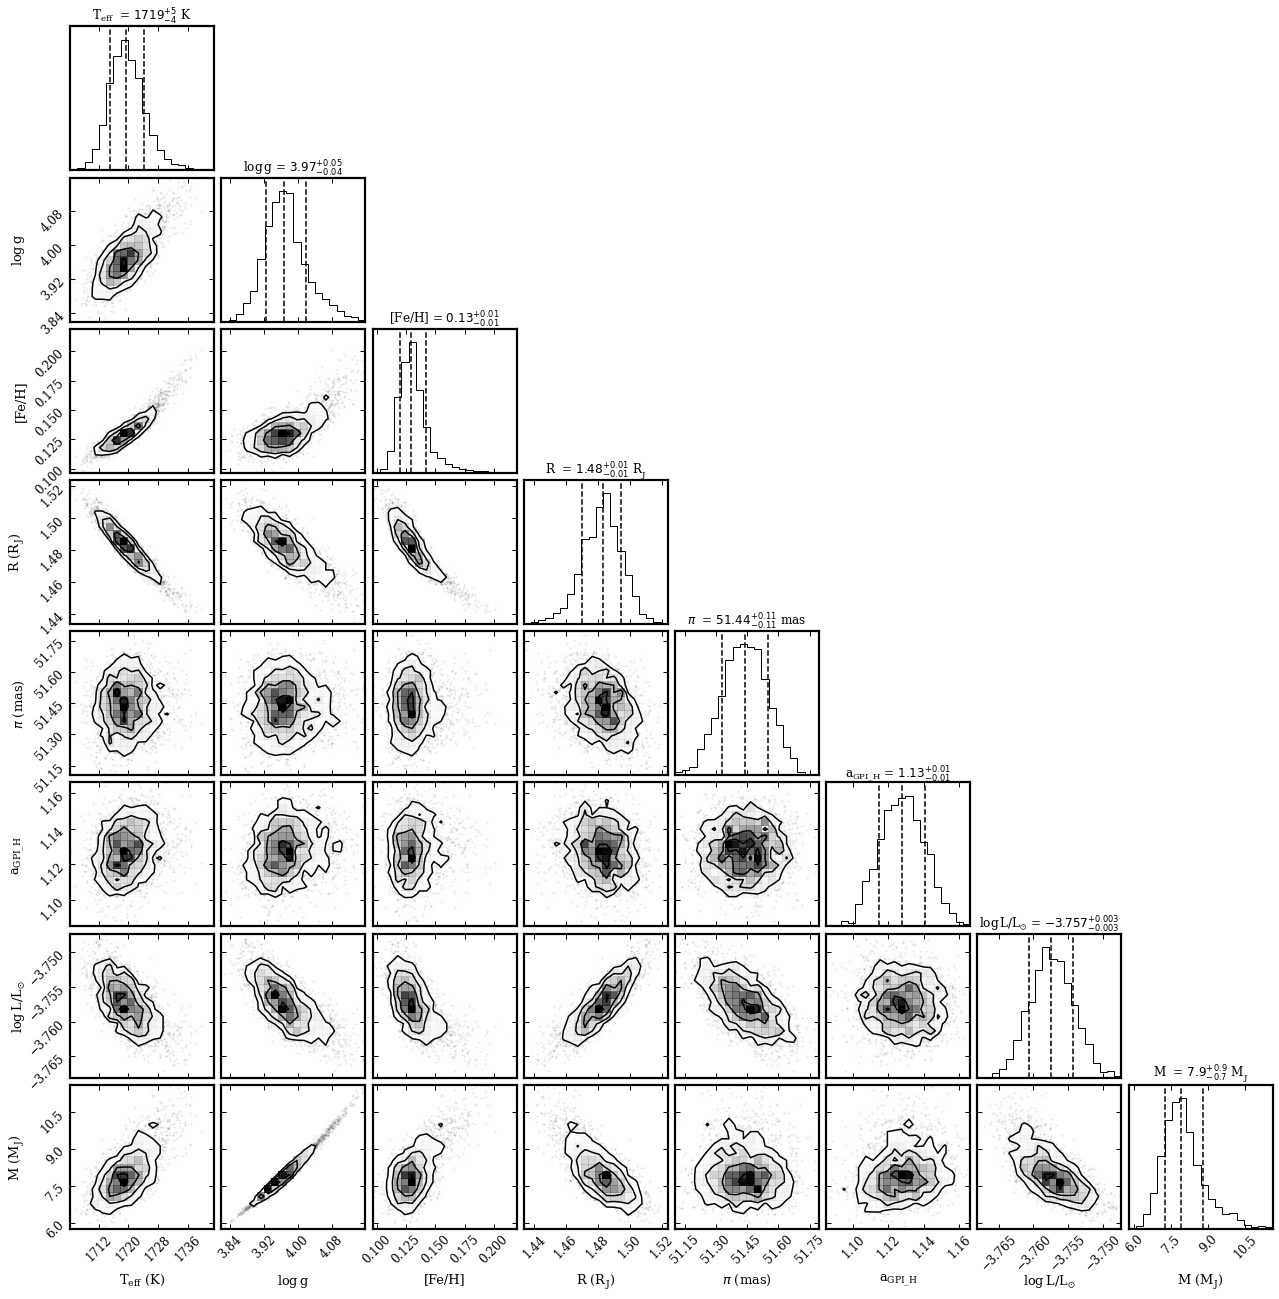

In [12]:
species.plot_posterior(tag='betapic',
                       offset=(-0.3 , -0.3),
                       title_fmt=['.0f', '.2f', '.2f', '.2f', '.2f', '.2f', '.3f', '.1f'],
                       inc_luminosity=True,
                       inc_mass=True,
                       output=None)

## Extracting boxes with results

We will now extract [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) objects with the results. These will be combined in a plot at the end of the tutorial. We start by selecting 30 random samples from the posterior and use these parameters to interpolate the DRIFT-PHOENIX grid. To do so, we use the [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_spectra) method of the [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database). We will smooth the spectra to a resolution of $R=500$ to match with the resolution of the GRAVITY spectrum.

In [13]:
samples = database.get_mcmc_spectra(tag='betapic',
                                    random=30,
                                    wavel_range=None,
                                    spec_res=500.)

Getting MCMC spectra: 100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 153.62it/s]


The function returned a list with 30 [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox) objects. Let's have a look at the content of the first box by running the [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box) method. This method can be used for all boxes to easily inspect the attributes of a [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) object.

In [14]:
samples[0].open_box()

Opening ModelBox...
model = drift-phoenix
type = None
wavelength = [ 0.1         0.10002476  0.10004953 ... 49.97524871 49.98762282
 50.        ]
flux = [2.28135989e-69 2.10383420e-69 1.87528020e-69 ... 2.07169466e-19
 2.06913400e-19 2.06730648e-19]
parameters = {'teff': 1721.6267865756652, 'logg': 3.972139346124936, 'feh': 0.12856649608628445, 'radius': 1.4783947036643863, 'parallax': 51.499197452238754, 'luminosity': 0.00017469381970180441, 'mass': 7.908494362248091}
quantity = flux
contribution = None
bol_flux = None


Instead of using the plotting functionalities of `species`, the attributes from a [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) can also be directly extracted for further processing. For example, to print the wavelengths of the first [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox) that was returned by [get_mcmc_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_mcmc_spectra):

In [15]:
print(samples[0].wavelength)

[ 0.1         0.10002476  0.10004953 ... 49.97524871 49.98762282
 50.        ]


Next, we get the median parameter values with the [get_median_sample](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_median_sample) method of the [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) and adopt these as best-fit parameters. Similarly, the [get_probable_sample](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_probable_sample) method can be used for extracting the sample with the maximum likelihood.

In [16]:
best = database.get_median_sample(tag='betapic')

The best-fit model spectrum is now extracted from the DRIFT-PHOENIX grid by using the functionalities of the [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel) class.

In [17]:
read_model = species.ReadModel(model='drift-phoenix',
                               wavel_range=None)

The grid is interpolated at the best-fit parameters with [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model). The argument of `model_param` contains the parameter dictionary that was returned by [get_median_sample](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_median_sample). The spectrum will be smoothed to a resolution of $R=500$. To extract the spectrum without smoothing at the resolution as stored in the database is achieved by setting `spec_res=None` and `smooth=False`.

In [18]:
modelbox = read_model.get_model(model_param=best,
                                spec_res=500.,
                                smooth=True)

/Users/tomasstolker/applications/species/species/read/read_model.py:696: UserWarning: The 'scaling_GPI_H' parameter is not required by 'drift-phoenix' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh'].
  warnings.warn(


Some warnings are printed because the `model_param` dictionary contained calibration parameters (that were fitted), but these are not required when reading a model spectrum.

We will also extract all spectra and photometric fluxes of beta Pic b with the [get_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_object) method which will return the output in an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox).

In [19]:
objectbox = database.get_object(object_name='beta Pic b',
                                inc_phot=True,
                                inc_spec=True)

Getting object: beta Pic b... [DONE]


We then run the [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) through the [update_spectra](https://species.readthedocs.io/en/latest/species.util.html#species.util.read_util.update_spectra) function with the best-fit parameters. This function applies the flux scaling and could also inflate the errors in case the `model_param` dictionary contains error inflation parameters.

In [20]:
objectbox = species.update_spectra(objectbox=objectbox,
                                   model_param=best)

Scaling the flux of GPI_H: 1.13... [DONE]


/Users/tomasstolker/applications/species/species/util/read_util.py:176: DeprecationWarning: The update_spectra function is deprecated and will be removed in a future release. Please use the update_objectbox function instead.
  warnings.warn(


Next, we calculate the residuals of the best-fit model with [get_residuals](https://species.readthedocs.io/en/latest/species.util.html#species.util.phot_util.get_residuals). This function will interpolate the grid at the specified parameters, calculate synthetic photometry for the filters that are provided as argument of `inc_phot`, and smooth and resample the spectra to the resolution and wavelengths of the spectra that are provided as argument of `inc_spec` (all spectra of the [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) in this case). The returned residuals will be stored in a [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox).

In [21]:
residuals = species.get_residuals(datatype='model',
                                  spectrum='drift-phoenix',
                                  parameters=best,
                                  objectbox=objectbox,
                                  inc_phot=inc_phot,
                                  inc_spec=True)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]
Residuals (sigma):
   - Paranal/NACO.Lp: -4.75
   - Paranal/NACO.NB374: -1.12
   - Paranal/NACO.NB405: -0.76
   - Paranal/NACO.Mp: -0.81
   - GPI_H: min: -1.17, max: 2.07
   - GPI_J: min: -1.91, max: 3.99
   - GPI_Y: min: -1.36, max: 1.37
   - GRAVITY: min: -5.69, max: 5.11
Reduced chi2 = 2.79
Number of degrees of freedom = 330


Finally, we compute synthetic photometry from the best-fit model spectrum with the [multi_photometry](https://species.readthedocs.io/en/latest/species.util.html#species.util.phot_util.multi_photometry) function. Since we will plot all available photometric data of the [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox), we will calculate synthetic photometry for all the names of the `filters` attribute of the [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox).

In [22]:
synphot = species.multi_photometry(datatype='model',
                                   spectrum='drift-phoenix',
                                   filters=objectbox.filters,
                                   parameters=best)

Calculating synthetic photometry... [DONE]


Let's have a look inside the `SynphotBox`.

In [23]:
synphot.open_box()

Opening SynphotBox...
name = synphot
flux = {'Gemini/NICI.ED286': 6.313100131660149e-15, 'Magellan/VisAO.Ys': 3.261934978977361e-15, 'Paranal/NACO.H': 6.023674177528963e-15, 'Paranal/NACO.J': 6.382730078161801e-15, 'Paranal/NACO.Ks': 4.9832619510599846e-15, 'Paranal/NACO.Lp': 2.007715791664406e-15, 'Paranal/NACO.Mp': 8.564256078585903e-16, 'Paranal/NACO.NB374': 2.0982081194013644e-15, 'Paranal/NACO.NB405': 1.6663501715060354e-15}


## Plotting the spectral energy distribution

Now that we have gather all the `Box` objects with the results, we can pass them as list to the `boxes` parameter of the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function. The [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox) is separately provided as argument of `residuals`. We also include a list of filter names for which the transmission profiles will be plotted. The arguments of `residuals` and `filters` can also be set to `None` to not include these data in the plot.

The somewhat complex part of [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) is the optional `plot_kwargs` parameter. The argument is a list with the same length as the list of `boxes`. Each item contains a dictionary with keyword arguments that can be used to fine-tune the styling of the plot. The item of the [SynphotBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.SynphotBox) can be set to `None` because it is automatically adjusted to the styles that are used for the [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox).

Plotting spectrum... [DONE]


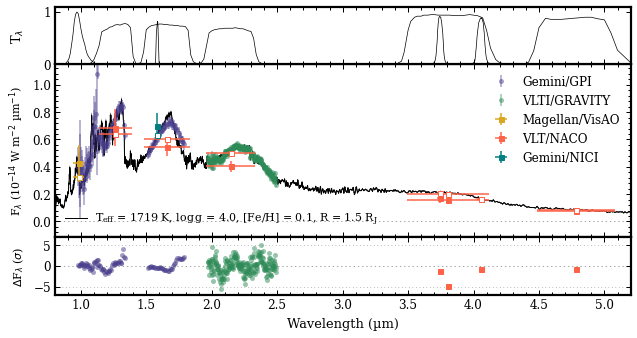

In [23]:
species.plot_spectrum(boxes=[samples, modelbox, objectbox, synphot],
                      filters=objectbox.filters,
                      residuals=residuals,
                      plot_kwargs=[{'ls': '-', 'lw': 0.2, 'color': 'gray'},
                                   {'ls': '-', 'lw': 1., 'color': 'black'},
                                   {'GRAVITY': {'marker': 'o', 'ms': 5., 'mew': 0., 'color': 'seagreen', 'ls': 'none', 'alpha': 0.5, 'label': 'VLTI/GRAVITY'},
                                    'GPI_Y': {'marker': 'o', 'ms': 5., 'mew': 0., 'color': 'darkslateblue', 'ls': 'none', 'alpha': 0.5, 'label': 'Gemini/GPI'},
                                    'GPI_J': {'marker': 'o', 'ms': 5., 'mew': 0., 'color': 'darkslateblue', 'ls': 'none', 'alpha': 0.5},
                                    'GPI_H': {'marker': 'o', 'ms': 5., 'mew': 0., 'color': 'darkslateblue', 'ls': 'none', 'alpha': 0.5},
                                    'Magellan/VisAO.Ys': {'marker': 's', 'ms': 5., 'color': 'goldenrod', 'ls': 'none', 'label': 'Magellan/VisAO'},
                                    'Gemini/NICI.ED286': {'marker': 's', 'ms': 5., 'color': 'teal', 'ls': 'none', 'label': 'Gemini/NICI'},
                                    'Paranal/NACO.J': {'marker': 's', 'ms': 5., 'color': 'tomato', 'ls': 'none', 'label': 'VLT/NACO'},
                                    'Paranal/NACO.H': {'marker': 's', 'ms': 5., 'color': 'tomato', 'ls': 'none'},
                                    'Paranal/NACO.Ks': {'marker': 's', 'ms': 5., 'color': 'tomato', 'ls': 'none'},
                                    'Paranal/NACO.NB374': {'marker': 's', 'ms': 5., 'color': 'tomato', 'ls': 'none'},
                                    'Paranal/NACO.Lp': {'marker': 's', 'ms': 5., 'color': 'tomato', 'ls': 'none'},
                                    'Paranal/NACO.NB405': {'marker': 's', 'markersize': 5., 'color': 'tomato', 'ls': 'none'},
                                    'Paranal/NACO.Mp': {'marker': 's', 'markersize': 5., 'color': 'tomato', 'ls': 'none'}},
                                    None],
                      xlim=(0.8, 5.2),
                      ylim=(-1.15e-15, 1.15e-14),
                      ylim_res=(-7., 7.),
                      scale=('linear', 'linear'),
                      offset=(-0.4, -0.05),
                      legend=[{'loc': 'lower left', 'frameon': False, 'fontsize': 11.},
                              {'loc': 'upper right', 'frameon': False, 'fontsize': 12.}],
                      figsize=(8., 4.),
                      quantity='flux density',
                      output=None)